In [1]:
import timeseries_qmc as ts

L = 4 #Number of sites
coupuling_list = [[0, 1], [1, 2], [2, 3], [3, 0]] # Connectivity of sites
Jzz = 1.0 # Strength of Coupling
hx = 1.0 # Strength of field
model = ts.models.Ising.from_coupling_list(L, coupuling_list, Jzz,  hx)

/Users/ghanem/opt/anaconda3/envs/ts_qmc/lib/python3.9/site-packages/tenpy/tools/optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import timeseries_qmc as ts
from tenpy.models import lattice

lattice = lattice.Square(3, 3, None, bc='periodic')
Jzz = 1.0 # Strength of Coupling
hx = 1.0 # Strength of field
model = ts.models.Ising.from_lattice(lattice, Jzz, hx)

In [3]:
beta = 0.3 # Inverse temperature
M2, E, E2 = model.calc_thermal_observables(beta) # Calculates: Manetization^2, Energy, Energy^2

Cv=(E2-E**2)*beta**2 # Specific heat
print("Magnetizaiton: {:.3f}".format(M2))
print("Specific Heat: {:.3f}".format(Cv))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Magnetizaiton: 0.474
Specific Heat: 3.866


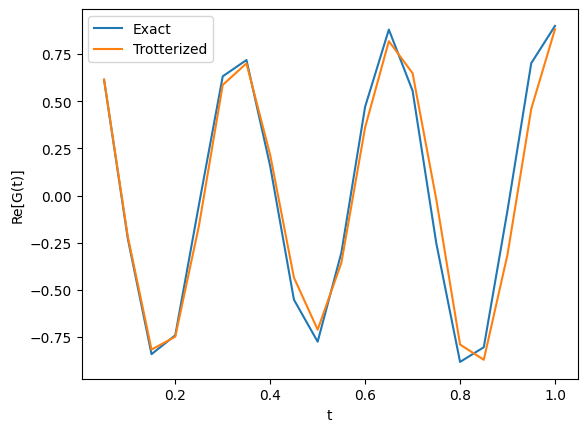

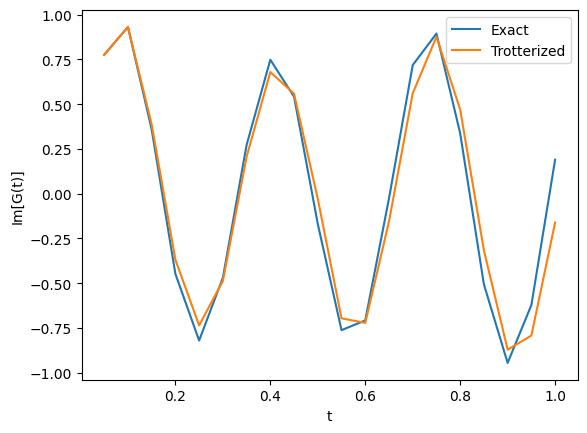

In [4]:
import numpy as np
import matplotlib.pylab as plt

n_t = 20 # Number of time points
t_max = 1.0 # Maximum time
dt = t_max/n_t
t = np.linspace(dt, t_max, n_t, endpoint=True) # Points at which to evaluate Loschmidt echos
psi =  model.n_qbits*[0] # Product state for which to evaluate Loschmidt echos

exact_loschmidt = ts.loschmidt.ExactLoschmidtEcho(model)
trotterized_loschmidt = ts.loschmidt.TrotterizedLoschmidtEcho(model, trotter_order=1, dt_trotter=0.25)

G_exact,_  = exact_loschmidt.evaluate(psi, t)
G_trotter,_  = trotterized_loschmidt.evaluate(psi, t)

plt.plot(t, G_exact.real, label="Exact")
plt.plot(t, G_trotter.real, label="Trotterized")
plt.xlabel("t")
plt.ylabel("Re[G(t)]")
plt.legend()
plt.show()

plt.plot(t, G_exact.imag, label="Exact")
plt.plot(t, G_trotter.imag, label="Trotterized")
plt.xlabel("t")
plt.ylabel("Im[G(t)]")
plt.legend()
plt.show()

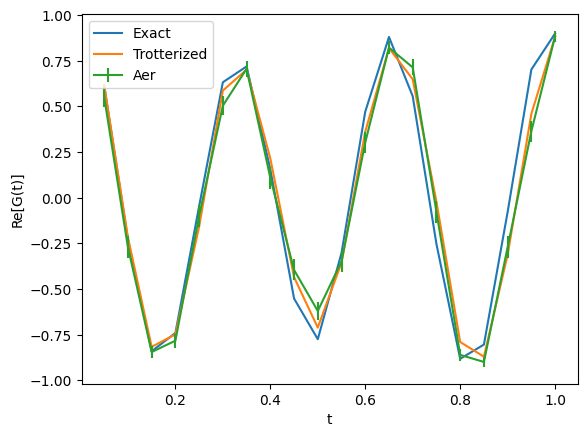

In [5]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
hadmard_loschmidt = ts.loschmidt.Hadamard(model, backend, n_shots = 256, cache_directory='tutorial_data', dt_trotter=0.25)
G_aer, G_aer_err  = hadmard_loschmidt.evaluate(psi, t)

plt.plot(t, G_exact.real, label="Exact")
plt.plot(t, G_trotter.real, label="Trotterized")
plt.errorbar(t, G_aer.real, yerr=G_aer_err.real, label="Aer")
plt.xlabel("t")
plt.ylabel("Re[G(t)]")
plt.legend()
plt.show()

In [6]:
exact_boltzmann = ts.boltzmann.ExactBoltzmannWeight(model, beta)
fourier_boltzmann = ts.boltzmann.FourierTransform(beta, exact_loschmidt, t_max=1.0, n_t = 20)
nnls_boltzmann = ts.boltzmann.NNLS(model, beta, exact_loschmidt, t_max=1.0, n_t = 20)

exact_weight, exact_e, exact_e2 = exact_boltzmann.calculate(psi)
fourier_weight, fourier_e, fourier_e2 = fourier_boltzmann.calculate(psi)
nnls_weight, nnls_e, nnls_e2 = nnls_boltzmann.calculate(psi)

print("Boltzmann Weight - Exact   : {:.3f}".format(exact_weight))
print("Boltzmann Weight - Fourier : {:.3f}".format(fourier_weight))
print("Boltzmann Weight - NNLS    : {:.3f}".format(nnls_weight))

Boltzmann Weight - Exact   : 272.950
Boltzmann Weight - Fourier : 319.610
Boltzmann Weight - NNLS    : 272.963


In [7]:
sampler = ts.sampling.ClusterUpdate(Jzz, beta, lattice=lattice)
rng_seed = 32 # Seed for random number generation
initial_sample = psi # Starting state
chain = ts.sampling.MarkovChain(exact_boltzmann, sampler, initial_sample, rng_seed)
n_samples = 100

for i in range(n_samples):
    chain.generate_next_sample()
    if((i+1)%10==0):
        print("Sample #{}: {}".format(i+1, chain.current_sample))

mag_vals = chain.get_magnetziations_squared()
print("")
print("Average Magnetizaiton: {:.3f}".format(np.mean(mag_vals)))

Sample #10: [1 0 1 1 0 1 1 1 1]
Sample #20: [0 0 0 0 0 0 0 0 0]
Sample #30: [1 0 0 1 1 1 1 1 1]
Sample #40: [1 1 1 1 0 1 1 1 1]
Sample #50: [0 0 0 1 0 0 0 0 0]


Sample #60: [0 1 1 0 1 1 1 1 0]
Sample #70: [1 1 1 1 1 1 1 1 1]


Sample #80: [0 1 1 1 1 1 1 0 1]
Sample #90: [0 0 0 0 0 0 0 0 0]
Sample #100: [1 1 1 1 0 1 1 1 1]

Average Magnetizaiton: 0.497


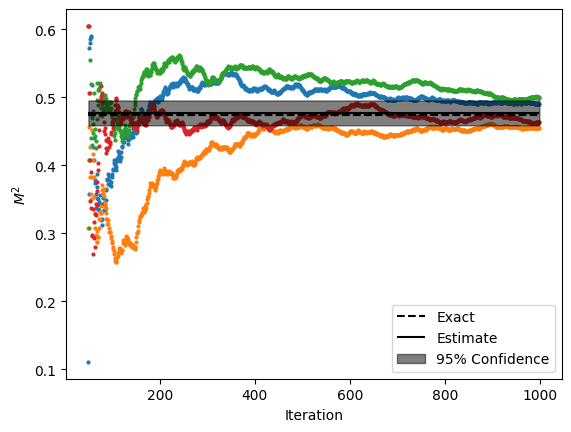

In [8]:
import math

chains = []
samples_num_per_chain = 1000
chains_num = 4
for rng_seed in range(chains_num):
    chain_filename = "./tutorial_data/chain_"+str(rng_seed)+".pickle"
    chain = ts.sampling.generate_chain(exact_boltzmann, sampler, initial_sample,
                            rng_seed, samples_num_per_chain, chain_filename)
    chains.append(chain)

num_burned_samples = 50
used_samples = list(range(num_burned_samples, samples_num_per_chain))
chains_estimates = []
for chain in chains:
    values = chain.get_magnetziations_squared()[used_samples]
    cum_means = np.cumsum(values)/np.arange(1, 1+len(values))
    plt.plot(used_samples, cum_means, 'o', ms=2)
    chain_estimate = np.mean(values)
    chains_estimates.append(chain_estimate)

chains_estimates = np.array(chains_estimates)
estimate = np.mean(chains_estimates)
error = 2*np.std(chains_estimates)/math.sqrt(chains_num) #Two standard deviations - 95% condfidence

plt.hlines(xmin=used_samples[0], xmax=used_samples[-1], y=M2, color="k", ls="--", label="Exact")
plt.hlines(xmin=used_samples[0], xmax=used_samples[-1], y=estimate,color="k", label="Estimate")
plt.fill_between(used_samples, estimate-error, estimate+error, color='k', zorder=2, alpha=0.5, label="95% Confidence")
plt.ylabel("$M^2$")
plt.xlabel("Iteration")
plt.legend()
plt.show()